In [2]:
# Lets load some librarues and car data and precalculated features
library(dplyr)
library(ggplot2)
library(glmnet)
library(corrplot)

load("data/fsecure.train.RData"); kori.class<-class

Warning message:
“package ‘dplyr’ was built under R version 3.3.2”
Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Warning message:
“package ‘ggplot2’ was built under R version 3.3.2”Warning message:
“package ‘glmnet’ was built under R version 3.3.2”Loading required package: Matrix
Loading required package: foreach
Warning message:
“package ‘foreach’ was built under R version 3.3.2”Loaded glmnet 2.0-5



In [3]:
head(autodata)

ajoneuvoluokka,ryhma,ajoneuvonkaytto,kayttoonottoVuosi,matkamittarilukema,vari,kori,kori.orig,kori.est,omamassa,⋯,suurinNettoteho,polttoaine,kuntanimi,Co2,Co2.orig,Co2.modelled,merkki,mallimerkinta,l.malli,malli
Henkilöauto,Henkilö,Yksityinen,1997,355890,Vihreä,Farmari,Farmari,Farmari,1320,⋯,66,Bensiini,Kouvola,205.3317,NA,205.3317,VOLKSWAGEN,5D PASSAT VARIANT 1.8 CL-351-C/263,PASSAT,PASSAT
Henkilöauto,Henkilö,Yksityinen,1984,NA,Ruskea,Viistoperä,NA,Viistoperä,780,⋯,NA,Bensiini,Oulu,179.9998,NA,179.9998,FORD,2D FIESTA 1.1-FBD/2280,FIESTA,FIESTA
Henkilöauto,Henkilö,Myyntivarasto,1990,NA,Valkoinen,Sedan,NA,Sedan,1060,⋯,88,Bensiini,Helsinki,204.1334,NA,204.1334,CITROEN,4D SEDAN BX 19 GTI-XBEY/2650,BX,BX
Henkilöauto,Henkilö,Yksityinen,2003,108731,Punainen,Viistoperä,Viistoperä,Viistoperä,955,⋯,43,Bensiini,Pori,143.0000,143,142.4133,RENAULT,2D CLIO HATCHBACK 1.2-CB0FCF/247,CLIO,CLIO
Henkilöauto,Henkilö,Yksityinen,2003,238435,Sininen,Sedan,Sedan,Sedan,1462,⋯,114,Bensiini,Tampere,190.0000,190,190.5217,HONDA,4D ACCORD SEDAN 2.0-CL75/268,ACCORD,ACCORD
Henkilöauto,Henkilö,Yksityinen,2006,109030,Hopea,Farmari,Farmari,Farmari,1270,⋯,81,Bensiini,Ähtäri,172.0000,172,171.8726,TOYOTA,5D COROLLA STW 1.6-ZZE121L-DWMNKW/260,COROLLA,COROLLA


In [17]:
# autodata contains a field kori.orig that is the original car type and 
# kori.est that has a prediction on the car type (sedan, wagon, ...)
# It's made using the brand and model information string, and a tree classifier (xgboost). 

select(autodata,merkki,mallimerkinta,kori.orig,kori.est) %>% head

# Theres plenty of missing data
count(autodata,is.na(kori.orig))

# Prediction accuracy (percentage)
mean(autodata$kori.est == autodata$kori.orig,na.rm=TRUE)*100

merkki,mallimerkinta,kori.orig,kori.est
VOLKSWAGEN,5D PASSAT VARIANT 1.8 CL-351-C/263,Farmari,Farmari
FORD,2D FIESTA 1.1-FBD/2280,NA,Viistoperä
CITROEN,4D SEDAN BX 19 GTI-XBEY/2650,NA,Sedan
RENAULT,2D CLIO HATCHBACK 1.2-CB0FCF/247,Viistoperä,Viistoperä
HONDA,4D ACCORD SEDAN 2.0-CL75/268,Sedan,Sedan
TOYOTA,5D COROLLA STW 1.6-ZZE121L-DWMNKW/260,Farmari,Farmari


is.na(kori.orig),n
FALSE,2206514
TRUE,457711


[1] 99.76438

In [22]:

# Let's demonstrate LASSO regression, cross-validation, and 

# X contains a sparse matrix where data "merkki+mallimerkinta" is divided by space and some punctuation 
# 5D PASSAT VARIANT 1.8 CL-351-C/263 => [5D, PASSAT, VARIANT, 1.8, CL, 351, C/263]
# and one-hot-coded into a sparse matrix X and class vector c
#
# This has been done elsewhere, and rows with missing class kori.orig are omitted

head(X)
head(class)

# lets make it a bit smaller, and take a 5% sample
sample.idx<-seq(1, dim(X)[1], 20)
select.vars<-colSums(X)>10

dim(X)
dim(X[sample.idx,select.vars])

   [[ suppressing 34 column names ‘’, ‘NA’, ‘5OV’ ... ]]


6 x 40219 sparse Matrix of class "dgCMatrix"
                                                                             
2  1 1 . 1 1 1 1 1 1 1 1 1 . . . . . . . . . . . . . . . . . . . . . . ......
3  1 1 . . . . . . . . . 1 1 1 1 1 1 1 1 1 1 . . . . . . . . . . . . . ......
5  1 1 . . . . . . . . . . . . . . . . . . . . 1 1 1 1 1 1 . . . . . . ......
8  1 1 . . . . . 1 1 1 . . . . . . . . . . . . . . . . . . 1 1 . . . . ......
10 1 1 1 . . . . 1 1 . . . . . . . . . . . . . . . . . . . . . . . . . ......
11 1 1 . . . . . . . . . 1 . . . . . . . . . . . . . . . . . . . . . . ......

 .....suppressing columns in show(); maybe adjust 'options(max.print= *, width = *)'
 ..............................

[1] "Matkailu" "Coupé"    "Matkailu" "Matkailu" "Matkailu" "Sedan"

[1] 70498 40219

[1] 3525 2527

In [23]:
# Multinomial classification, ten folds 
classifier <-cv.glmnet(X[sample.idx, select.vars],
             as.factor(kori.class[sample.idx]),
             type.measure="deviance",
             family="multinomial",
             alpha=1,
             nfolds=10)


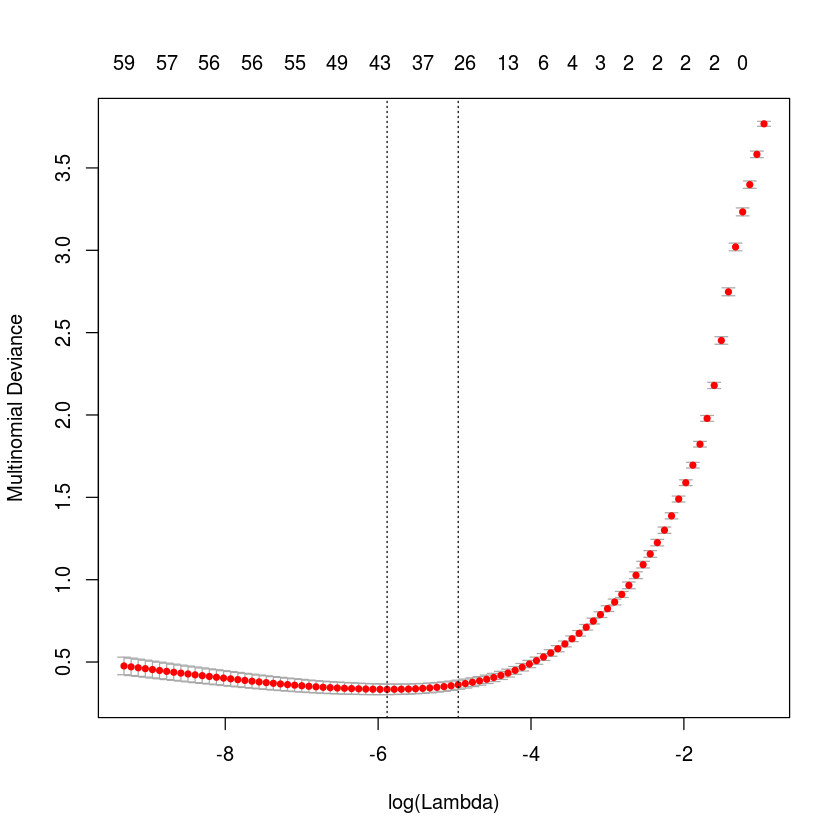

In [24]:
# Lets see some statistics (deviation is not =classification error)
plot(classifier)

In [26]:
#Lets predict using the best model and see the accuracy!

mean(kori.class == predict(classifier, X[,select.vars], type="class"))*100

[1] 96.14173

In [27]:
# Let's see the confusion matrix!
# kori.orig (true car type) is capitalized

table(toupper(class), predict(lasso.model,X[,select.vars], type="class")) %>% 
  prop.table(.,2) 


            
                      Avo        Coupé      Farmari     Matkailu   Monikäyttö
  AVO        0.9925558313 0.0047555357 0.0008956059 0.0003854060 0.0004611837
  COUPÉ      0.0026881720 0.9876653292 0.0003358522 0.0005138746 0.0001537279
  FARMARI    0.0000000000 0.0004458315 0.9794010635 0.0032117163 0.0138355111
  MATKAILU   0.0002067825 0.0000000000 0.0015113350 0.9784172662 0.0127594158
  MONIKÄYTTÖ 0.0002067825 0.0000000000 0.0149454240 0.0128468654 0.9684857802
  MUU        0.0016542597 0.0000000000 0.0009515813 0.0028263104 0.0032282859
  SEDAN      0.0022746071 0.0050527567 0.0011754828 0.0003854060 0.0006149116
  VIISTOPERÄ 0.0004135649 0.0020805469 0.0007836552 0.0014131552 0.0004611837
            
                      Muu        Sedan   Viistoperä
  AVO        0.0000000000 0.0071288637 0.0003964583
  COUPÉ      0.0000000000 0.0151284284 0.0070040967
  FARMARI    0.0011961722 0.0143121463 0.0015858332
  MATKAILU   0.0322966507 0.0144209839 0.0000000000
  MONIKÄYTTÖ

In [38]:
# Lets see the coefficients 

coef(lasso.model)$Sedan

2528 x 1 sparse Matrix of class "dgCMatrix"
                               1
(Intercept)         0.5021775144
                    .           
NA                  .           
5OV                 .           
160                 .           
MULTIJET            .           
PÖSSL               .           
MATKAILUAUTO        .           
SA                  .           
3OV                 .           
2999CM3             .           
A                   .           
2D                  .           
HT                  .           
COUPE               .           
COUPÉ               .           
AD                  .           
2OV                 .           
5750CM3             .           
590CM3              .           
D                   .           
570                 .           
E                   .           
ADRIATIK            .           
2464CM3             .           
CORAL               .           
680                 .           
SP                  .           

In [48]:
# Let's see this a bit better
cf<-coef(lasso.model)$Sedan
data.frame(attr=rownames(cf), coef=as.numeric(cf)) %>% 
arrange(-coef)


attr,coef
SEDAN,3.8608878
SEDN,3.4129022
SEC,3.0964817
4DSEDAN,2.8511402
2DSEDAN,2.7395703
VAUXHALL,2.0067546
CAPRI,1.8461210
CONSUL,1.8461197
MONACO,1.8461036
SIX,1.7931276
